# 1.0 Imports

## | 1.1 Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from statsmodels.tsa.api import SimpleExpSmoothing

C:\Users\Neil\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# colors
data_color = "#313131" # grey
model_color = "#00bbf9" # blue
background_color = "#f5f5f5" #light grey
grid_color = "#DADADA" # mid grey

# graphs
graph_width = 18
graph_height = 5

## | 1.2 Data

In [3]:
data = pd.read_csv("./data/covid_19_indonesia_time_series_all.csv")

# check data is loaded as expected
pd.set_option("display.max_columns", None)
data.head()

,Date,Location ISO Code,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Location Level,City or Regency,Province,Country,Continent,Island,Time Zone,Special Status,Total Regencies,Total Cities,Total Districts,Total Urban Villages,Total Rural Villages,Area (km2),Population,Population Density,Longitude,Latitude,New Cases per Million,Total Cases per Million,New Deaths per Million,Total Deaths per Million,Total Deaths per 100rb,Case Fatality Rate,Case Recovered Rate,Growth Factor of New Cases,Growth Factor of New Deaths
0,3/1/2020,ID-JK,DKI Jakarta,2,0,0,2,39,20,41,-22,Province,NaN,DKI Jakarta,Indonesia,Asia,Jawa,UTC+07:00,Daerah Khusus Ibu Kota,1,5.0,44,267.0,NaN,664,10846145,16334.31,106.836118,-6.204699,0.18,3.60,0.0,1.84,0.18,51.28%,105.13%,NaN,NaN
1,3/2/2020,ID-JK,DKI Jakarta,2,0,0,2,41,20,41,-20,Province,NaN,DKI Jakarta,Indonesia,Asia,Jawa,UTC+07:00,Daerah Khusus Ibu Kota,1,5.0,44,267.0,NaN,664,10846145,16334.31,106.836118,-6.204699,0.18,3.78,0.0,1.84,0.18,48.78%,100.00%,1.0,1.0
2,3/2/2020,IDN,Indonesia,2,0,0,2,2,0,0,2,Country,NaN,NaN,Indonesia,Asia,NaN,NaN,NaN,416,98.0,7230,8488.0,74953.0,1916907,265185520,138.34,113.921327,-0.789275,0.01,0.01,0.0,0.00,0.00,0.00%,0.00%,NaN,NaN
3,3/2/2020,ID-RI,Riau,1,0,0,1,2,0,3,-1,Province,NaN,Riau,Indonesia,Asia,Sumatera,UTC+07:00,NaN,10,2.0,169,268.0,1591.0,87024,6074100,69.80,101.805109,0.511648,0.16,0.33,0.0,0.00,0.00,0.00%,150.00%,NaN,NaN
4,3/3/2020,ID-JK,DKI Jakarta,2,0,0,2,43,20,41,-18,Province,NaN,DKI Jakarta,Indonesia,Asia,Jawa,UTC+07:00,Daerah Khusus Ibu Kota,1,5.0,44,267.0,NaN,664,10846145,16334.31,106.836118,-6.204699,0.18,3.96,0.0,1.84,0.18,46.51%,95.35%,1.0,1.0


In [4]:
# check number of columns and rows matches the source
data.shape

(21759, 38)

# 2.0 Data Cleaning

## | 2.1 Data Types

In [5]:
# check data types are appropriate for intended use
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21759 entries, 0 to 21758
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date                         21759 non-null  object 
 1   Location ISO Code            21759 non-null  object 
 2   Location                     21759 non-null  object 
 3   New Cases                    21759 non-null  int64  
 4   New Deaths                   21759 non-null  int64  
 5   New Recovered                21759 non-null  int64  
 6   New Active Cases             21759 non-null  int64  
 7   Total Cases                  21759 non-null  int64  
 8   Total Deaths                 21759 non-null  int64  
 9   Total Recovered              21759 non-null  int64  
 10  Total Active Cases           21759 non-null  int64  
 11  Location Level               21759 non-null  object 
 12  City or Regency              0 non-null      float64
 13  Province        

In [6]:
# change the date data type to avoid errors in time series sorting
data['Date'] = pd.to_datetime(data['Date'], format="%m/%d/%Y")

## | 2.2 Missing Values

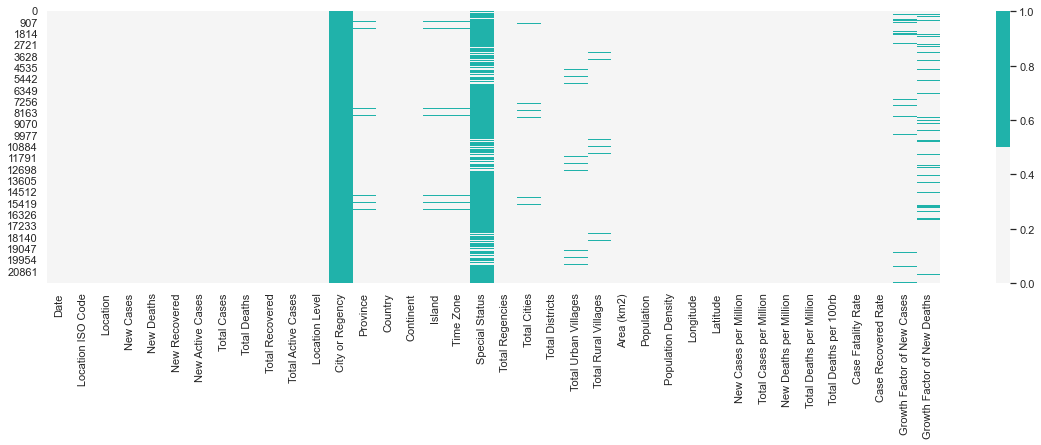

In [7]:
# visualise missing values using a heat map
colours = ["whitesmoke", "lightseagreen"]
sns.set(rc={"figure.figsize": (20, 5)})
sns.heatmap(data.isnull(), cmap=sns.color_palette(colours));

In [8]:
# drop columns with missing values that will not or cannot be filled
data = data.drop(
    [
        "City or Regency",
        "Province",
        "Island",
        "Time Zone",
        "Special Status",
        "Total Cities",
        "Total Urban Villages",
        "Total Rural Villages",
        "Growth Factor of New Deaths",
    ],
    axis=1,
)

# drop columns expected to be unrelated to research questions
data = data.drop(
    [
        "Location ISO Code",
        "Location Level",
        "Country",
        "Continent",
        "Total Regencies",
        "Total Districts",
        "Longitude",
        "Latitude",
        "New Cases per Million",
        "Total Cases per Million",
        "New Deaths per Million",
        "Total Deaths per Million",
        "Total Deaths per 100rb",
        "Case Fatality Rate",
        "Case Recovered Rate",
    ],
    axis=1,
)

In [9]:
# function to avoid divide by 0 errors
def safe_division(numerator, denominator):
    return denominator and numerator / denominator

# blank dataframe for updated dataframes to be added to
updated = pd.DataFrame()

# list of the unique locations in the dataset
unique_locations = data.Location.unique()

# loop through the unique locations and update the growth factor of new cases column
for location in unique_locations:

    # filter dataframe by location name and sort by date
    location = data[data["Location"] == location]
    location = location.sort_values(by=["Date"], ignore_index=True)

    # set the value of the first instance with no previous day data to 0
    location.loc[0, "Growth Factor of New Cases"] = 0

    # variable for loop removes the header row to avoid out of range error
    entries = len(location) - 1

    # variable to start on the first instance with previous day data
    i = 1

    # loop through all rows and calculate the growth factor
    for rows in range(entries):

        new = location.loc[i, "New Cases"]
        previous = location.loc[i - 1, "New Cases"]

        # updates value by dividing new cases with previous day new cases
        location.loc[i, "Growth Factor of New Cases"] = safe_division(new, previous)

        i += 1

    # rebuilds the dataset by adding the updated dataframes to the main dataframe
    updated = pd.concat([updated, location])

# check updated dataframe instances match original imported dataframe
updated.shape[0] == data.shape[0]

# reindex the updated dataset by date
updated = updated.sort_values(by=["Date"],ignore_index=True)

In [10]:
# one-hot encoding growth rate as increasing or decreasing for use in classifier
updated["Increasing"] = np.where(updated["Growth Factor of New Cases"] >= 1, 1, 0)

# drop the subsequently unneeded column
updated = updated.drop(["Growth Factor of New Cases"], axis=1,)

# check new column is populated as expected
updated.head()

,Date,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Area (km2),Population,Population Density,Increasing
0,2020-03-01,DKI Jakarta,2,0,0,2,39,20,41,-22,664,10846145,16334.31,0
1,2020-03-02,Riau,1,0,0,1,2,0,3,-1,87024,6074100,69.80,0
2,2020-03-02,Indonesia,2,0,0,2,2,0,0,2,1916907,265185520,138.34,0
3,2020-03-02,DKI Jakarta,2,0,0,2,41,20,41,-20,664,10846145,16334.31,1
4,2020-03-03,DKI Jakarta,2,0,0,2,43,20,41,-18,664,10846145,16334.31,1


In [11]:
# check no missing values remain
updated.isnull().sum()

Date                  0
Location              0
New Cases             0
New Deaths            0
New Recovered         0
New Active Cases      0
Total Cases           0
Total Deaths          0
Total Recovered       0
Total Active Cases    0
Area (km2)            0
Population            0
Population Density    0
Increasing            0
dtype: int64

## | 2.3 Check Duplicates

In [12]:
# check data for duplicate rows
updated[updated.duplicated()]

,Date,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Area (km2),Population,Population Density,Increasing


## | 2.4 Data Filtering

In [13]:
# seperate national and regional data into seperate datasets
national = updated[updated['Location'] == "Indonesia"]
regional = updated[updated['Location'] != "Indonesia"]

# resort and reindex
national = national.sort_values(by=["Date"],ignore_index=True)
regional = regional.sort_values(by=["Date"],ignore_index=True)

# drop columns in national data set with static values
national = national.drop(['Area (km2)', 'Population', 'Population Density'],axis=1)

In [14]:
# check of country dataset filter actions
national.head()

,Date,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Increasing
0,2020-03-02,Indonesia,2,0,0,2,2,0,0,2,0
1,2020-03-03,Indonesia,0,0,0,0,2,0,0,2,0
2,2020-03-04,Indonesia,0,0,0,0,2,0,0,2,0
3,2020-03-05,Indonesia,0,0,0,0,2,0,0,2,0
4,2020-03-06,Indonesia,2,0,0,2,4,0,0,4,0


In [15]:
# check of regional dataset filter actions
regional.head()

,Date,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Area (km2),Population,Population Density,Increasing
0,2020-03-01,DKI Jakarta,2,0,0,2,39,20,41,-22,664,10846145,16334.31,0
1,2020-03-02,Riau,1,0,0,1,2,0,3,-1,87024,6074100,69.80,0
2,2020-03-02,DKI Jakarta,2,0,0,2,41,20,41,-20,664,10846145,16334.31,1
3,2020-03-03,DKI Jakarta,2,0,0,2,43,20,41,-18,664,10846145,16334.31,1
4,2020-03-03,Riau,0,0,0,0,2,0,3,-1,87024,6074100,69.80,0


In [16]:
# check for entries where the derived population density value is inaccurate
display(regional.loc[(np.floor(regional["Population Density"]) != np.floor((regional["Population"] / regional["Area (km2)"])))])

,Date,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Area (km2),Population,Population Density,Increasing


In [17]:
# check for entries where the derived new active case value is inaccurate
display(regional.loc[(regional["New Active Cases"] != (regional["New Cases"] - regional["New Deaths"] - regional["New Recovered"]))])

,Date,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Area (km2),Population,Population Density,Increasing


## | 2.5 Detecting Outliers

In [18]:
# who culmulative totals as of January 3rd 2022
who_cases = 4266195
who_deaths = 144129

# check for impossible values that exceeding lagged who figures
national[(national["Total Cases"] >= who_cases) | (national["Total Deaths"] >= who_deaths)]

,Date,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Increasing


### || 2.5.1 National Data

C:\Users\Neil\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


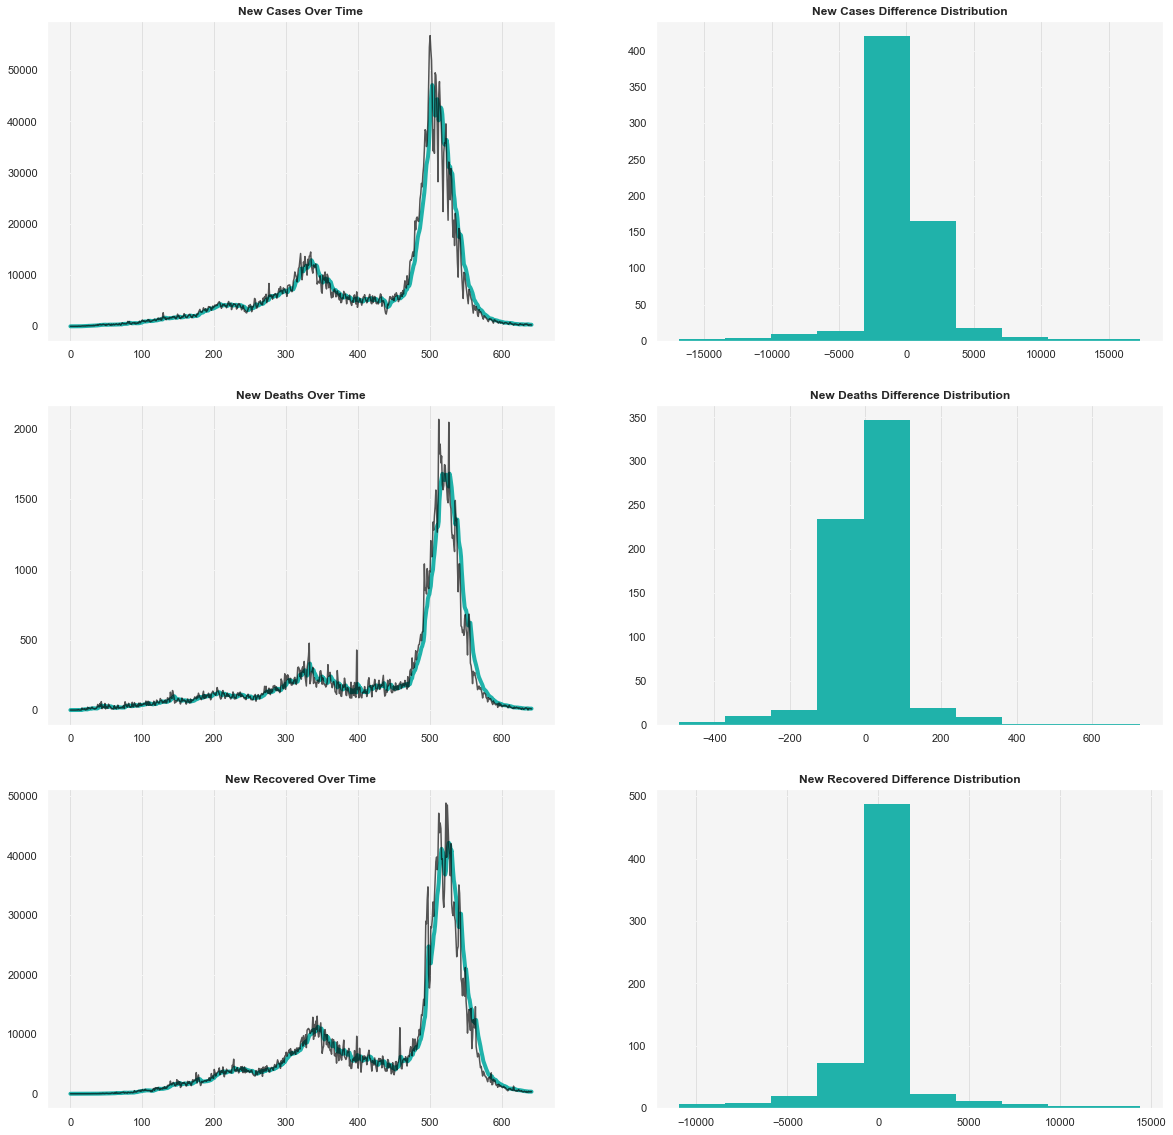

In [19]:
# all column names to be inspected for outliers
attributes = ["New Cases", "New Deaths", "New Recovered"]

for attribute in attributes:

    # loop to calculate moving average exponential smoothing for each attribute
    ema_fit = SimpleExpSmoothing(national[attribute]).fit(smoothing_level=0.2,optimized=False)
    ema = ema_fit.forecast(3).rename(r'$\alpha=0.2$')
    
    # creates new columns to hold model calculations
    national[attribute + ' EMA'] = ema_fit.predict(start = 0)
    national[attribute + ' Difference'] = national[attribute] - national[attribute + ' EMA']

# list for looping through subplot graphs
rows = [0,1,2]
columns = [0,1]
ema_titles = ['New Cases Over Time', 'New Cases Difference Distribution', 'New Deaths Over Time', 'New Deaths Difference Distribution', 'New Recovered Over Time', 'New Recovered Difference Distribution']

# graph display settings
fig, ax = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

# loop to set background colors and ema_titles for each subplot
k=0
for i in range(len(rows)):
    for j in range(len(columns)):
        ax[i,j].set_facecolor('whitesmoke')
        ax[i,j].set_title(ema_titles[k],fontweight='bold')
        ax[i,j].grid(color='#E0E0E0', linestyle='-', linewidth=1, axis='x')
        ax[i,j].grid(color='whitesmoke', linestyle='-', linewidth=1, axis='y')
        #ax[i,j].set_facecolor('whitesmoke')
        k+=1

# loop for scatterplots and histographs for each attribute
l=0
for attribute in attributes:
    ax[l, 0].plot(national[attribute + ' EMA'], color = "lightseagreen", lw=4)
    ax[l, 0].plot(national[attribute], color = "black", alpha=0.66);
    ax[l, 1].hist(national[attribute + ' Difference'], color = "lightseagreen", lw=0);
    l+=1

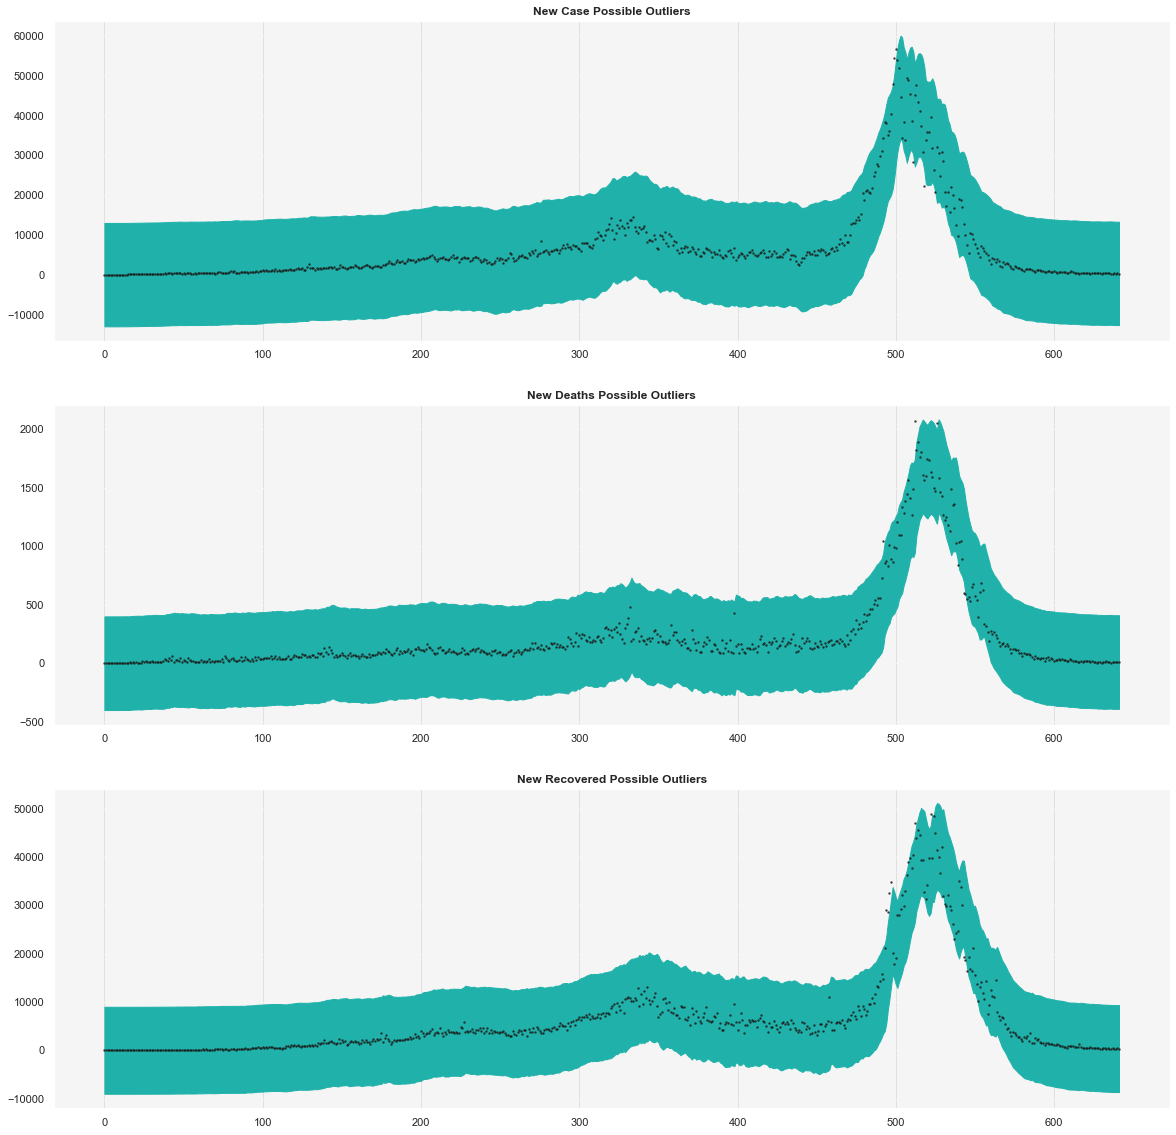

In [20]:
# adjust values to capture most of histogram data and identify expected outliers 
national_cases_range = 13000
national_deaths_range = 400
national_recovered_range = 9000
ranges = [national_cases_range, national_deaths_range,national_recovered_range]

outlier_titles = ["New Case Possible Outliers", "New Deaths Possible Outliers", "New Recovered Possible Outliers"]

fig, ax = plt.subplots(3)

i=0
for attribute in attributes:
    national[attribute + ' Upper'] = national[attribute + ' EMA'] + ranges[i]
    national[attribute + ' Lower'] = national[attribute + ' EMA'] - ranges[i]

    ax[i].plot(national[attribute],'k.',markersize=3,label='Actual', alpha=0.66)
    ax[i].fill_between(np.arange(national.shape[0]), national[attribute + ' Lower'], national[attribute + ' Upper'], color="lightseagreen",label="Predicted interval")
    
    ax[i].set_title(outlier_titles[i],fontweight='bold')
    ax[i].grid(color='#E0E0E0', linestyle='-', linewidth=1, axis='x')
    ax[i].grid(color='whitesmoke', linestyle='-', linewidth=1, axis='y')
    ax[i].set_facecolor('whitesmoke')
    
    i+=1

fig.set_figwidth(20)
fig.set_figheight(20)

### || 2.5.2 Regional Data

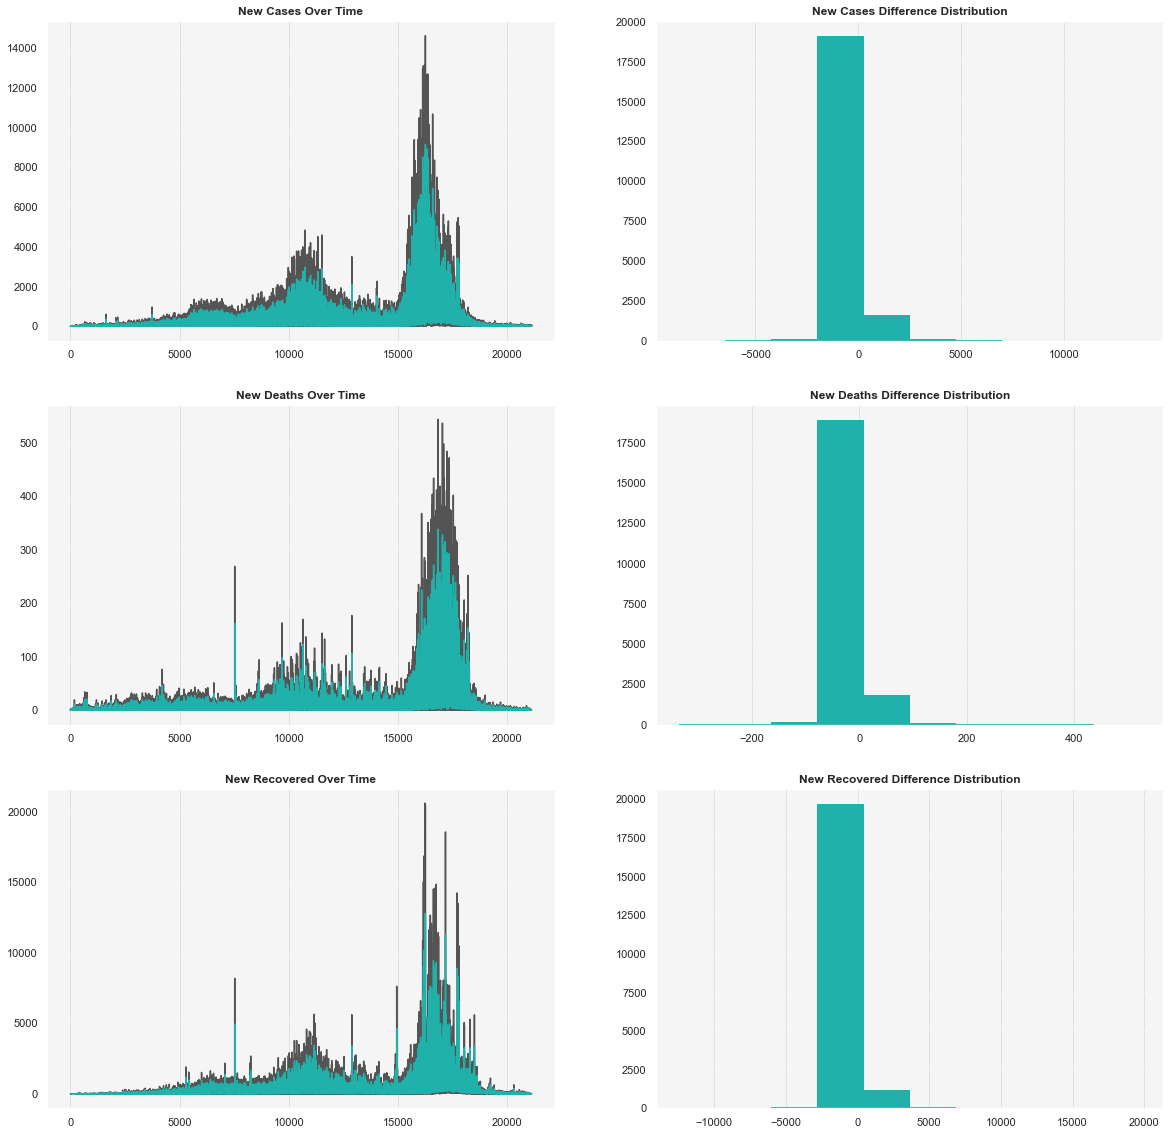

In [21]:
for attribute in attributes:

    # loop to calculate moving average exponential smoothing for each attribute
    ema_fit = SimpleExpSmoothing(regional[attribute]).fit(smoothing_level=0.6,optimized=False)
    ema = ema_fit.forecast(3).rename(r'$\alpha=0.2$')
    
    # creates new columns to hold model calculations
    regional[attribute + ' EMA'] = ema_fit.predict(start = 0)
    regional[attribute + ' Difference'] = regional[attribute] - regional[attribute + ' EMA']

# graph display settings
fig, ax = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

# loop to set background colors and ema_titles for each subplot
k=0
for i in range(len(rows)):
    for j in range(len(columns)):
        ax[i,j].set_facecolor('whitesmoke')
        ax[i,j].set_title(ema_titles[k],fontweight='bold')
        ax[i,j].grid(color='#E0E0E0', linestyle='-', linewidth=1, axis='x')
        ax[i,j].grid(color='whitesmoke', linestyle='-', linewidth=1, axis='y')
        ax[i,j].set_facecolor('whitesmoke')
        k+=1

# loop for scatterplots and histographs for each attribute
l=0
for attribute in attributes:
    
    ax[l, 0].plot(regional[attribute], color = "black", alpha=0.66);
    ax[l, 0].plot(regional[attribute + ' EMA'], color = "lightseagreen")
    ax[l, 1].hist(regional[attribute + ' Difference'], color = "lightseagreen", lw=0);
    l+=1

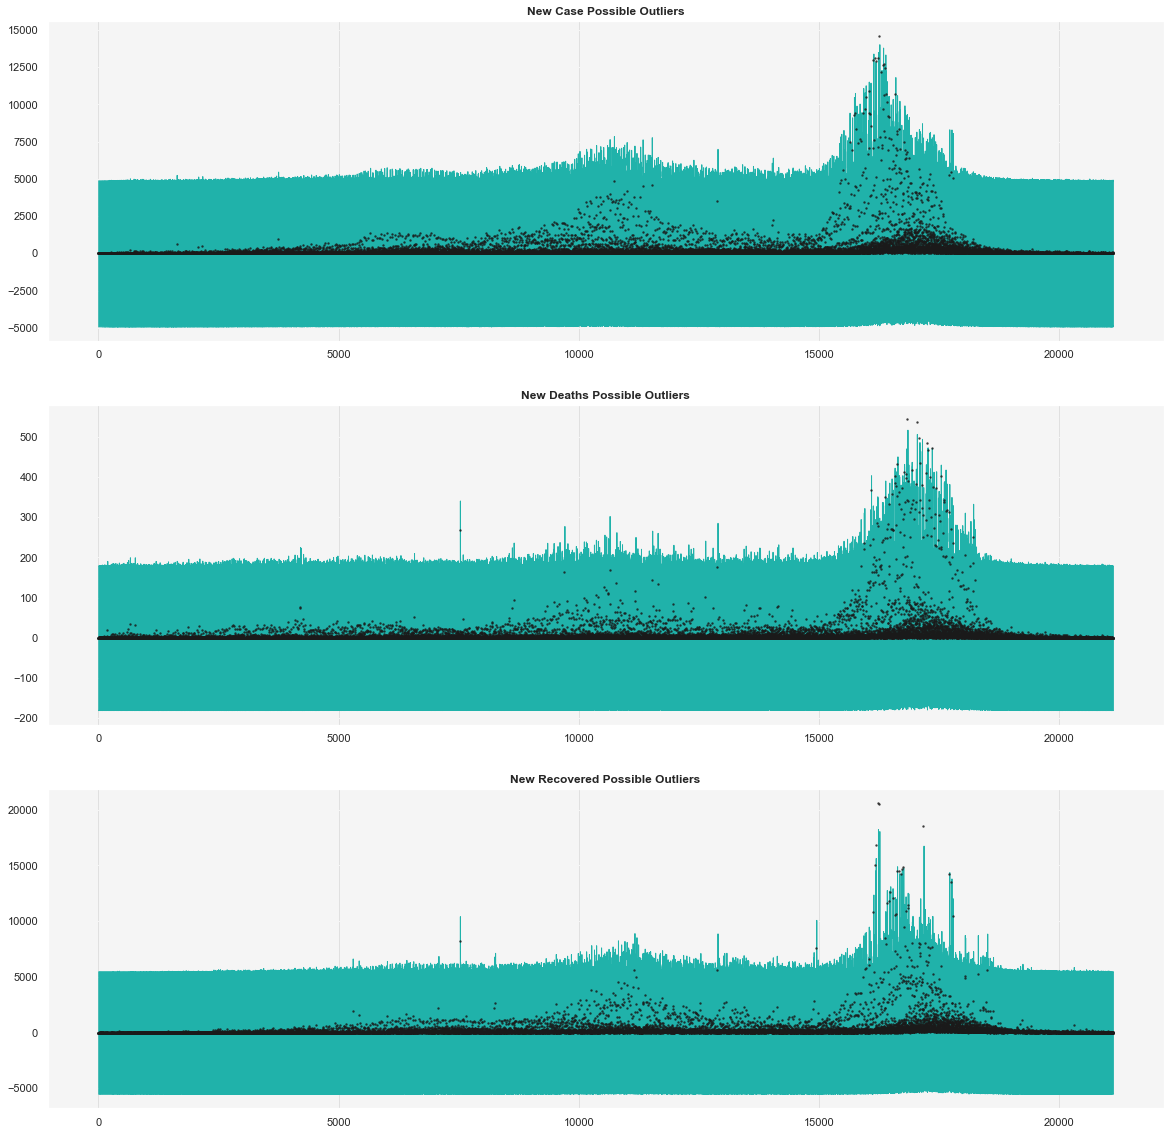

In [22]:
# inspect histograms and determine how far the majority of data differs from the moving averange
regional_cases_range = 4900
regional_deaths_range = 180
regional_recovered_range = 5500
ranges = [regional_cases_range, regional_deaths_range,regional_recovered_range]

outlier_titles = ["New Case Possible Outliers", "New Deaths Possible Outliers", "New Recovered Possible Outliers"]

fig, ax = plt.subplots(3)

i=0
for attribute in attributes:
    regional[attribute + ' Upper'] = regional[attribute + ' EMA'] + ranges[i]
    regional[attribute + ' Lower'] = regional[attribute + ' EMA'] - ranges[i]

    ax[i].plot(regional[attribute],'k.',markersize=3,label='Actual', alpha=0.66)
    ax[i].fill_between(np.arange(regional.shape[0]), regional[attribute + ' Lower'], regional[attribute + ' Upper'], color="lightseagreen",label="Predicted interval")
    
    ax[i].set_title(outlier_titles[i],fontweight='bold')
    ax[i].grid(color='#E0E0E0', linestyle='-', linewidth=1, axis='x')
    ax[i].grid(color='whitesmoke', linestyle='-', linewidth=1, axis='y')
    ax[i].set_facecolor('whitesmoke')
    
    i+=1

fig.set_figwidth(20)
fig.set_figheight(20)

In [23]:
# optional: use interactive graph to identify outliers in national/regional new cases/deaths/recovered columns
# fig = px.scatter(regional["New Cases"])
# fig.update_layout(showlegend=False, plot_bgcolor = "whitesmoke")

In [24]:
national_cleaned = national
regional_cleaned = regional

# replace outliers with ema value in national_cleaned dataframe
for attribute in attributes:
    national_cleaned[attribute] = np.where(
        national_cleaned[attribute] > national_cleaned[attribute + " Upper"],
        national_cleaned[attribute + " EMA"],
        national_cleaned[attribute],
    )
    
    national_cleaned[attribute] = np.where(
        national_cleaned[attribute] < national_cleaned[attribute + " Lower"],
        national_cleaned[attribute + " EMA"],
        national_cleaned[attribute],
    )
    
# replacing spike outliers not picked up by ema process
national_cleaned["New Deaths"] = np.where((national_cleaned["Date"] == '2021-01-28') & (national_cleaned["New Deaths"] == 476), national_cleaned["New Deaths EMA"], national_cleaned["New Deaths"])
national_cleaned["New Deaths"] = np.where((national_cleaned["Date"] == '2021-04-04') & (national_cleaned["New Deaths"] == 427), national_cleaned["New Deaths EMA"], national_cleaned["New Deaths"])

national_cleaned["New Recovered"] = np.where((national_cleaned["Date"] == '2021-06-03') & (national_cleaned["New Recovered"] == 11092), national_cleaned["New Recovered EMA"], national_cleaned["New Recovered"])

regional_cleaned["New Cases"] = np.where((regional_cleaned["Date"] == '2021-08-25') & (regional_cleaned["New Cases"] == 5463), regional_cleaned["New Cases EMA"], regional_cleaned["New Cases"])
regional_cleaned["New Cases"] = np.where((regional_cleaned["Date"] == '2021-08-26') & (regional_cleaned["New Cases"] == 5059), regional_cleaned["New Cases EMA"], regional_cleaned["New Cases"])
regional_cleaned["New Cases"] = np.where((regional_cleaned["Date"] == '2021-08-24') & (regional_cleaned["New Cases"] == 5254), regional_cleaned["New Cases EMA"], regional_cleaned["New Cases"])
regional_cleaned["New Cases"] = np.where((regional_cleaned["Date"] == '2021-04-04') & (regional_cleaned["New Cases"] == 3501), regional_cleaned["New Cases EMA"], regional_cleaned["New Cases"])
regional_cleaned["New Cases"] = np.where((regional_cleaned["Date"] == '2021-02-17') & (regional_cleaned["New Cases"] == 4507), regional_cleaned["New Cases EMA"], regional_cleaned["New Cases"])
regional_cleaned["New Cases"] = np.where((regional_cleaned["Date"] == '2021-02-23') & (regional_cleaned["New Cases"] == 4593), regional_cleaned["New Cases EMA"], regional_cleaned["New Cases"])

regional_cleaned["New Deaths"] = np.where((regional_cleaned["Date"] == '2020-10-28') & (regional_cleaned["New Deaths"] == 269), regional_cleaned["New Deaths EMA"], regional_cleaned["New Deaths"])
regional_cleaned["New Deaths"] = np.where((regional_cleaned["Date"] == '2021-04-04') & (regional_cleaned["New Deaths"] == 177), regional_cleaned["New Deaths EMA"], regional_cleaned["New Deaths"])
regional_cleaned["New Deaths"] = np.where((regional_cleaned["Date"] == '2020-12-31') & (regional_cleaned["New Deaths"] == 163), regional_cleaned["New Deaths EMA"], regional_cleaned["New Deaths"])
regional_cleaned["New Deaths"] = np.where((regional_cleaned["Date"] == '2021-07-07') & (regional_cleaned["New Deaths"] == 368), regional_cleaned["New Deaths EMA"], regional_cleaned["New Deaths"])
regional_cleaned["New Deaths"] = np.where((regional_cleaned["Date"] == '2021-09-07') & (regional_cleaned["New Deaths"] == 252), regional_cleaned["New Deaths EMA"], regional_cleaned["New Deaths"])

regional_cleaned["New Recovered"] = np.where((regional_cleaned["Date"] == '2020-10-28') & (regional_cleaned["New Recovered"] == 8184), regional_cleaned["New Recovered EMA"], regional_cleaned["New Recovered"])
regional_cleaned["New Recovered"] = np.where((regional_cleaned["Date"] == '2021-04-04') & (regional_cleaned["New Recovered"] == 5599), regional_cleaned["New Recovered EMA"], regional_cleaned["New Recovered"])
regional_cleaned["New Recovered"] = np.where((regional_cleaned["Date"] == '2021-06-03') & (regional_cleaned["New Recovered"] == 7622), regional_cleaned["New Recovered EMA"], regional_cleaned["New Recovered"])
                                       
# drop columns used to calculate outliers
national_cleaned = national_cleaned.drop(["New Cases EMA", "New Cases Difference", "New Deaths EMA", "New Deaths Difference", "New Recovered EMA", "New Recovered Difference", "New Cases Upper", "New Cases Lower", "New Deaths Upper", "New Deaths Lower", "New Recovered Upper", "New Recovered Lower"],axis=1,)
regional_cleaned = regional_cleaned.drop(["New Cases EMA", "New Cases Difference", "New Deaths EMA", "New Deaths Difference", "New Recovered EMA", "New Recovered Difference", "New Cases Upper", "New Cases Lower", "New Deaths Upper", "New Deaths Lower", "New Recovered Upper", "New Recovered Lower"],axis=1,)

In [25]:
# visual check of changes
national_cleaned.head(0)

,Date,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Increasing


In [26]:
# visual check of changes
regional_cleaned.head(0)

,Date,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Area (km2),Population,Population Density,Increasing


# 3.0 Data Exploration

# 4.0 Save Data

In [27]:
# save each subset to its own file
national_cleaned.to_csv('./data/national_cleaned.csv', index = True)
regional_cleaned.to_csv('./data/regional_cleaned.csv', index = True)

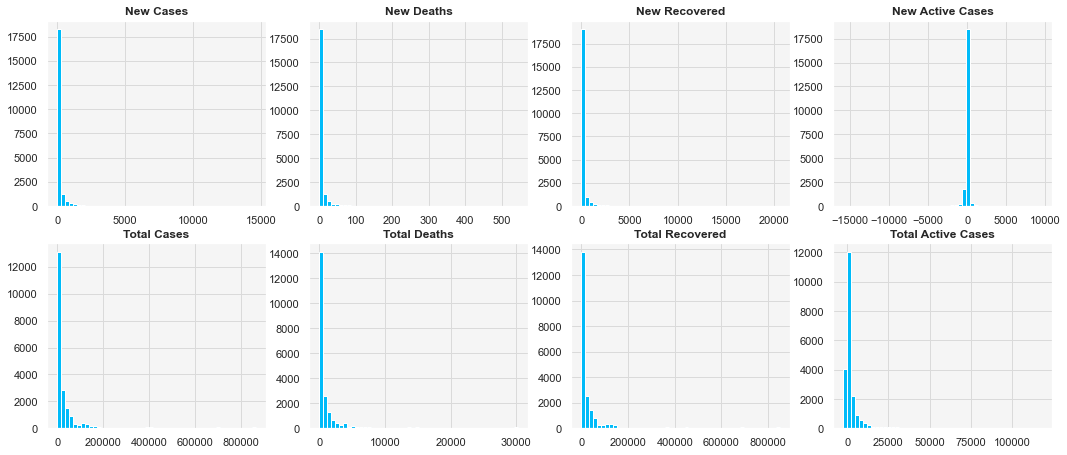

In [45]:
# display settings for the plot
fig, ax = plt.subplots(2, 4)
fig.set_figwidth(graph_width)
fig.set_figheight(graph_height*1.5)

regional_explored=regional_cleaned[["New Cases", "New Deaths", "New Recovered", "New Active Cases", "Total Cases", "Total Deaths", "Total Recovered", "Total Active Cases"]]

k=0
for i in range(2):
    for j in range(4):
        ax[i,j].set_title(regional_explored.columns[k],fontweight='bold')
        ax[i,j].hist(regional_explored[regional_explored.columns[k]], color=model_color, bins=50)
    
        ax[i,j].set_facecolor(background_color)
        ax[i,j].grid(color=grid_color)
        
        k+=1

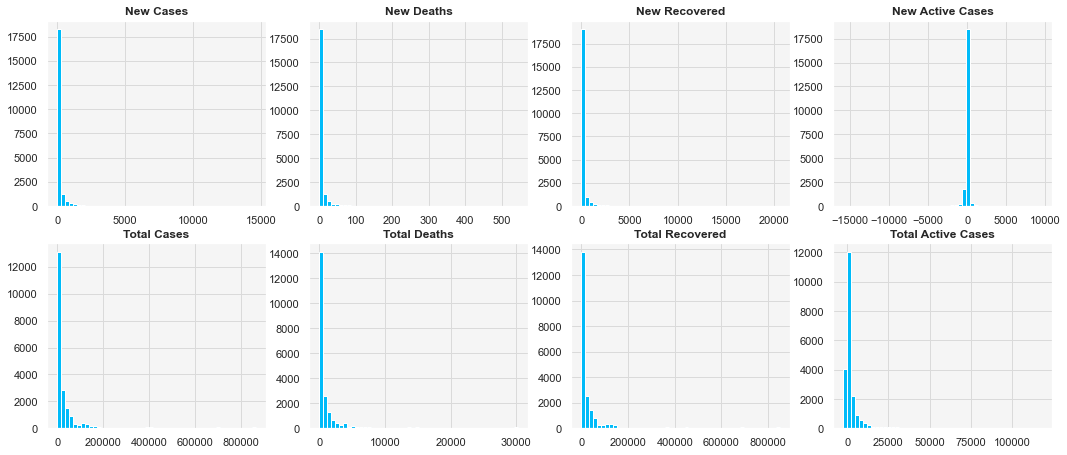

In [46]:
# display settings for the plot
fig, ax = plt.subplots(2, 4)
fig.set_figwidth(graph_width)
fig.set_figheight(graph_height*1.5)

national_explored=national_cleaned[["New Cases", "New Deaths", "New Recovered", "New Active Cases", "Total Cases", "Total Deaths", "Total Recovered", "Total Active Cases"]]

k=0
for i in range(2):
    for j in range(4):
        ax[i,j].set_title(regional_explored.columns[k],fontweight='bold')
        ax[i,j].hist(regional_explored[regional_explored.columns[k]], color=model_color, bins=50)
    
        ax[i,j].set_facecolor(background_color)
        ax[i,j].grid(color=grid_color)
        
        k+=1

In [47]:
regional_cleaned.describe()

,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Area (km2),Population,Population Density,Increasing
count,21117.000000,21117.000000,21117.000000,21117.000000,21117.000000,21117.000000,21117.000000,21117.000000,21117.000000,2.111700e+04,21117.000000,21117.000000
mean,200.335862,6.752616,193.356673,0.420467,43853.423308,1367.888100,39467.440261,3018.094947,56345.861723,7.886560e+06,763.433178,0.420372
std,660.935689,26.243263,699.118804,432.896047,110094.277374,3727.119504,103545.209805,8044.884933,60153.377954,1.086073e+07,2782.528073,0.493630
min,0.000000,0.000000,0.000000,-15797.000000,1.000000,0.000000,0.000000,-2306.000000,664.000000,6.484070e+05,8.590000,0.000000
25%,6.000000,0.000000,4.000000,-15.000000,1685.000000,46.000000,949.000000,172.000000,16787.000000,1.999539e+06,47.790000,0.000000
50%,38.000000,1.000000,29.000000,0.000000,10245.000000,261.000000,8167.000000,849.000000,38744.000000,4.216171e+06,103.840000,0.000000
75%,133.000000,4.000000,126.000000,25.000000,34118.000000,949.000000,30240.000000,2398.000000,72981.000000,8.217551e+06,262.700000,1.000000
max,14622.000000,544.000000,20602.000000,9537.000000,864045.000000,30225.000000,849875.000000,118018.000000,319036.000000,4.516132e+07,16334.310000,1.000000


In [53]:
regional_cleaned[regional_cleaned['Increasing'] < 1].count()

Date                  12240
Location              12240
New Cases             12240
New Deaths            12240
New Recovered         12240
New Active Cases      12240
Total Cases           12240
Total Deaths          12240
Total Recovered       12240
Total Active Cases    12240
Area (km2)            12240
Population            12240
Population Density    12240
Increasing            12240
dtype: int64

In [52]:
regional_cleaned[regional_cleaned['Increasing'] >= 1].count()

Date                  8877
Location              8877
New Cases             8877
New Deaths            8877
New Recovered         8877
New Active Cases      8877
Total Cases           8877
Total Deaths          8877
Total Recovered       8877
Total Active Cases    8877
Area (km2)            8877
Population            8877
Population Density    8877
Increasing            8877
dtype: int64